### Importing Libs

In [2]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow_hub import KerasLayer

2023-05-19 10:21:17.288205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 10:21:17.717092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 10:21:17.719379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 10:21:19.543433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
%matplotlib inline

In [14]:
MODEL_DIR = "text_models"
DATADIR = '../datasets'

### Loading Data

In [15]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATADIR, DATASET_NAME)
COLUMNS = ["title", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


### Data Prep

In [17]:
CLASSES = {"github": 0, "nytimes": 1, "techcrunch": 2}
N_CLASSES = len(CLASSES)

In [18]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [19]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

### Splitting

In [21]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

In [22]:
sources_train.value_counts()

github        34662
techcrunch    29383
nytimes       27347
Name: source, dtype: int64

In [23]:
sources_valid.value_counts()

github        1863
techcrunch    1508
nytimes       1440
Name: source, dtype: int64

In [24]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

### NNLM Model

In [27]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True
)

In [28]:
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

2023-05-19 10:25:07.294173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sentences' with dtype string and shape [?]
	 [[{{node sentences}}]]


<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

### Swivel Model

In [30]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True
)

In [31]:
swivel_module(tf.constant(["The dog is happy to see people in the street."]))

2023-05-19 10:25:26.513203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sentences' with dtype string and shape [?]
	 [[{{node sentences}}]]


<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.9967701 , -0.3100155 ,  0.5889897 , -0.16765082, -0.6171738 ,
        -1.1586996 , -0.8619045 ,  0.7281645 ,  0.32575002,  0.4754492 ,
        -0.9272241 ,  0.41090095, -0.75389475, -0.31525993, -1.8918804 ,
         0.6423996 ,  0.6801622 , -0.1335669 , -1.0017993 , -0.11908641]],
      dtype=float32)>

### Building Model

In [33]:
def build_model(hub_module, name):
    model = Sequential(
        [
            hub_module,  # TODO 2
            Dense(16, activation="relu"),
            Dense(N_CLASSES, activation="softmax"),
        ],
        name=name,
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [34]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train,
        Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(patience=1), TensorBoard(model_dir)],
    )
    return history

### Train NNLM

In [35]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [36]:
nnlm_model = build_model(nnlm_module, "nnlm")
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

2023-05-19 10:29:36.898672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


Epoch 1/100


2023-05-19 10:29:37.241873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,50]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-05-19 10:29:37.242001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype int64 and shape [?]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]


19/19 [==============================] - 16s 814ms/step - loss: 1.0569 - accuracy: 0.4519 - val_loss: 0.9998 - val_accuracy: 0.5837
Epoch 2/100
19/19 [==============================] - 15s 793ms/step - loss: 0.9355 - accuracy: 0.6581 - val_loss: 0.8573 - val_accuracy: 0.7071
Epoch 3/100
19/19 [==============================] - 16s 775ms/step - loss: 0.7791 - accuracy: 0.7395 - val_loss: 0.7001 - val_accuracy: 0.7637
Epoch 4/100
19/19 [==============================] - 15s 783ms/step - loss: 0.6332 - accuracy: 0.7845 - val_loss: 0.5782 - val_accuracy: 0.7930
Epoch 5/100
19/19 [==============================] - 15s 810ms/step - loss: 0.5244 - accuracy: 0.8150 - val_loss: 0.4946 - val_accuracy: 0.8140
Epoch 6/100
19/19 [==============================] - 15s 764ms/step - loss: 0.4467 - accuracy: 0.8374 - val_loss: 0.4404 - val_accuracy: 0.8304
Epoch 7/100
19/19 [==============================] - 15s 805ms/step - loss: 0.3905 - accuracy: 0.8552 - val_loss: 0.4069 - val_accuracy: 0.8416
Epoc

<Axes: >

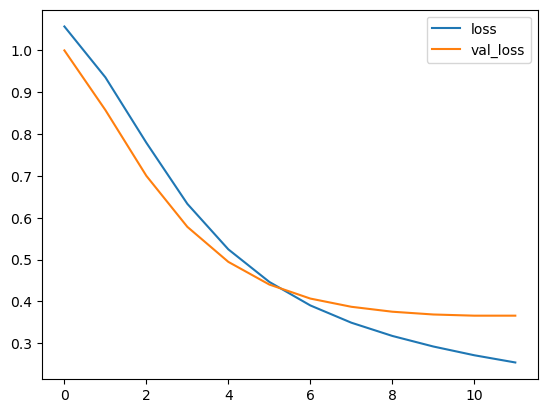

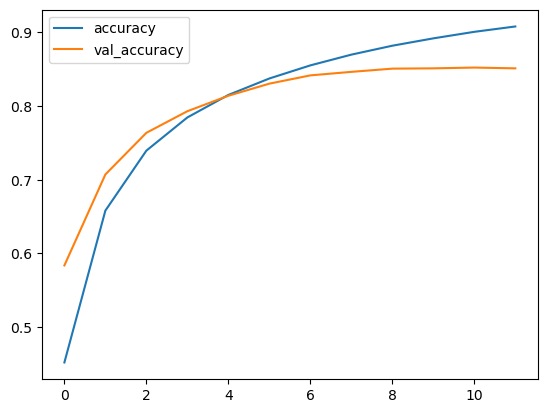

In [37]:
history = nnlm_history
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

### Train Swivel

In [40]:
swivel_model = build_model(swivel_module, name="swivel")

2023-05-19 10:32:40.741595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


In [41]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

Epoch 1/100


2023-05-19 10:32:40.959724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-05-19 10:32:40.959855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype int64 and shape [?]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]


19/19 [==============================] - 1s 27ms/step - loss: 1.1170 - accuracy: 0.4003 - val_loss: 1.0792 - val_accuracy: 0.4255
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 1.0467 - accuracy: 0.4626 - val_loss: 1.0172 - val_accuracy: 0.4974
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.9886 - accuracy: 0.5213 - val_loss: 0.9611 - val_accuracy: 0.5481
Epoch 4/100
19/19 [==============================] - 0s 18ms/step - loss: 0.9334 - accuracy: 0.5663 - val_loss: 0.9071 - val_accuracy: 0.5899
Epoch 5/100
19/19 [==============================] - 0s 21ms/step - loss: 0.8793 - accuracy: 0.6021 - val_loss: 0.8542 - val_accuracy: 0.6182
Epoch 6/100
19/19 [==============================] - 0s 19ms/step - loss: 0.8268 - accuracy: 0.6327 - val_loss: 0.8036 - val_accuracy: 0.6477
Epoch 7/100
19/19 [==============================] - 0s 16ms/step - loss: 0.7768 - accuracy: 0.6584 - val_loss: 0.7568 - val_accuracy: 0.6699
Epoch 8/100
19/19 

<Axes: >

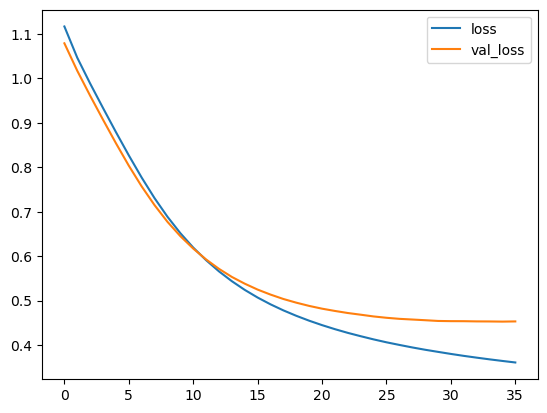

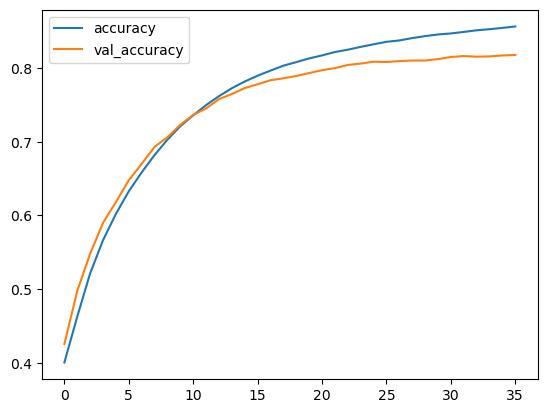

In [42]:
history = swivel_history
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

### Compare models

In [47]:
!tensorboard --logdir $MODEL_DIR --host 0.0.0.0 --port 6006

2023-05-19 10:33:55.969040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
TensorBoard 2.12.3 at http://0.0.0.0:6006/ (Press CTRL+C to quit)
^C


### Export model

In [49]:
OUTPUT_DIR = "./savedmodels_vertex"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join(OUTPUT_DIR, "swivel")
os.environ["EXPORT_PATH"] = EXPORT_PATH

shutil.rmtree(EXPORT_PATH, ignore_errors=True)

tf.keras.models.save_model(swivel_model, EXPORT_PATH)

2023-05-19 10:34:15.614285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'keras_layer_1_input' with dtype string and shape [?]
	 [[{{node keras_layer_1_input}}]]
2023-05-19 10:34:15.657004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-19 10:34:15.665790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'keras_layer_1_input' with dtype string and shape [?]
	 [[{{no

INFO:tensorflow:Assets written to: ./savedmodels_vertex/swivel/assets


INFO:tensorflow:Assets written to: ./savedmodels_vertex/swivel/assets


In [50]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}

2023-05-19 10:34:22.187352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_1_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_keras_layer_1_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall_1:0
Method name is: tensorflow/serving/predict
./savedmodels_vertex/swivel
./savedmodels_vertex/swivel/variables
./savedmodels_vertex/swivel/variables/variables.data-00000-of-00001
./savedmodels_vertex/swivel/variables/variables.index
./savedmodels_vertex/swivel/assets
./savedmodels_vertex/swivel/assets/tokens.txt
./savedmodels_vertex/swivel/keras_metadata.pb
./savedmodels_vertex/swivel/saved_model.pb
./savedmodels_vertex/swivel/fingerprint.pb
